# Harris County Home Price Estimations


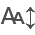

In [1]:
import os
import sqlite3
from datetime import datetime

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from itables import init_notebook_mode, show
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from load_to_dataframe import load_data_frame

init_notebook_mode(all_interactive=True)

# Load Data From SQLite Database
In the file **load_to_dataframe.py** there is a function that will connect to the database and run a query that will join 4 files on the building_res table and do much of the data preprocessing and the following filters are applied:
* Only houses with improvement type 1001 (single family homes) will be selected
* The date erected must be greater than 1900
* The assessed value must be greater than 0
* the square footage must be greater than 50

In [2]:
df = load_data_frame()

# Haversine Function
The haversine function is used to calculate the distance between two sets of latitude and longitude coordinates. In this case one of the fixed points is the center of downtown Houston (29.760100, -95.370100). The assumption is, the closer to Houston's downtown, the higher the value.

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in miles
    r = 3958.8
    # Convert degrees to radians
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    # Haversine formula
    a = np.sin(d_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return r * c


# Define the single point (latitude, longitude) to calculate the distance from
single_point = (29.760100, -95.370100)  # Houston

# Add a new column with distances
df["distance_miles"] = df.apply(
    lambda row: haversine(single_point[0], single_point[1], row["latitude"], row["longitude"]),
    axis=1,
)

# Price Per Square Foot
This is another metric that I will explore to see if there is a relationship between other values. This data will be cleaned and also a test since any property with 0 square feet will return a divide by zero error, so the row will be dropped.

In [4]:
df["assessed_per_sqft"] = df["assessed_per_sqft"].replace([np.inf, -np.inf], np.nan)

In [5]:
df["assessed_per_sqft"].describe()

count    1.115156e+06
mean     1.824132e+02
std      3.866353e+02
min      1.785714e+00
25%      1.248015e+02
50%      1.440565e+02
75%      1.728197e+02
max      3.432030e+04
Name: assessed_per_sqft, dtype: float64

# Reduce data set to a manageable size
The current data set is over 1.1M rows. This would take **DAYS** to train a model on a regular computer. This is after the initial filtering when extracting the data from the SQLite database.

To reduce the number of houses and remove outliers I will use the inner quartile range to remove the outliers.


In [6]:
print(f'There are {df.shape[0]:,} rows and {df.shape[1]} columns in the df Data Frame.')

There are 1,115,156 rows and 32 columns in the df Data Frame.


In [7]:
# IQR
Q1 = df["assessed_val"].quantile(0.25)
Q3 = df["assessed_val"].quantile(0.75)
IQR = Q3 - Q1

lower_iqr = Q1 - 1.5 * IQR
upper_iqr = Q3 + 1.5 * IQR
print(f"Lower IQR: {lower_iqr} | Upper IQR: {upper_iqr}")

df = df[(df['assessed_val'] <= upper_iqr)]

Lower IQR: -42777.5 | Upper IQR: 652866.5


In [8]:
y_market = df["tot_mkt_val"]
y = df["assessed_val"]
y_bld_val = df["bld_val"]
y_per_sqft = df["assessed_per_sqft"]

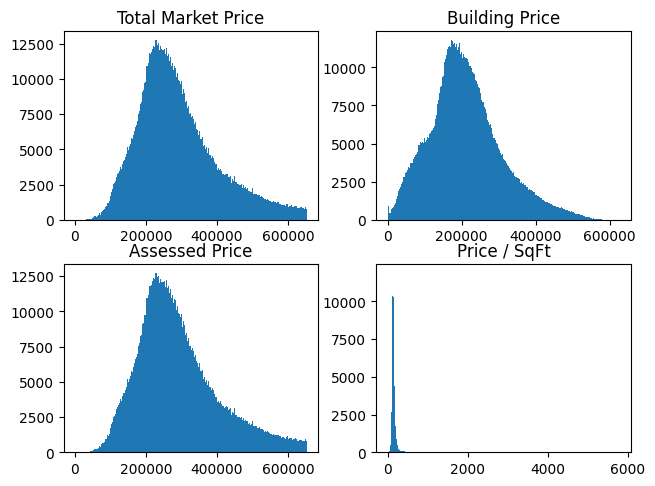

In [9]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

# Total Market Price
axs[0, 0].hist(y_market, bins="auto")
axs[0, 0].set_title("Total Market Price")

# Assessed values
axs[1, 0].hist(y, bins="auto")
axs[1, 0].set_title("Assessed Price")

# Building value
axs[0, 1].hist(y_bld_val, bins="auto")
axs[0, 1].set_title("Building Price")

# Price per square foot
axs[1, 1].hist(y_per_sqft, bins="auto")
axs[1, 1].set_title("Price / SqFt")

plt.show()

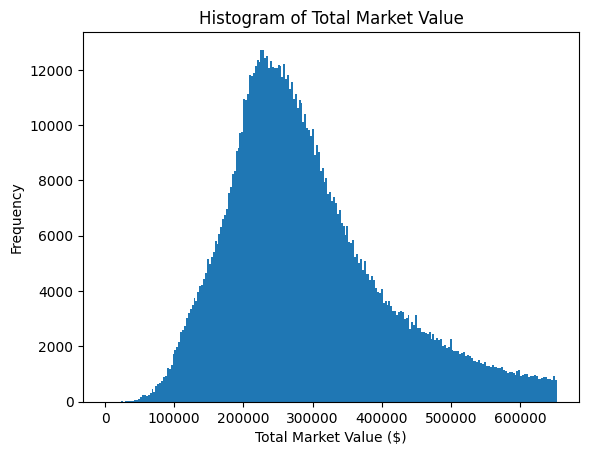

In [10]:
plt.hist(df["tot_mkt_val"], bins="auto")
plt.xlabel("Total Market Value ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Total Market Value")
plt.show()

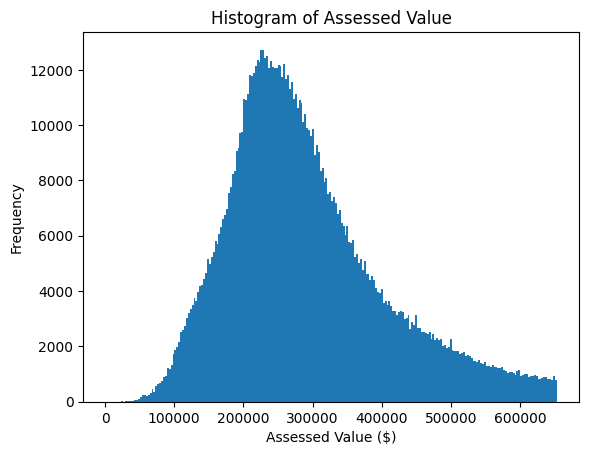

In [11]:
plt.hist(df["assessed_val"], bins="auto")
plt.xlabel("Assessed Value ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Assessed Value")
plt.show()

## Sample Size Reduction
Since the data set is still over 1M homes, we need to reduce the size to create a model.

In [12]:
sample_df = df.sample(n=10000, random_state=42)
show(sample_df)

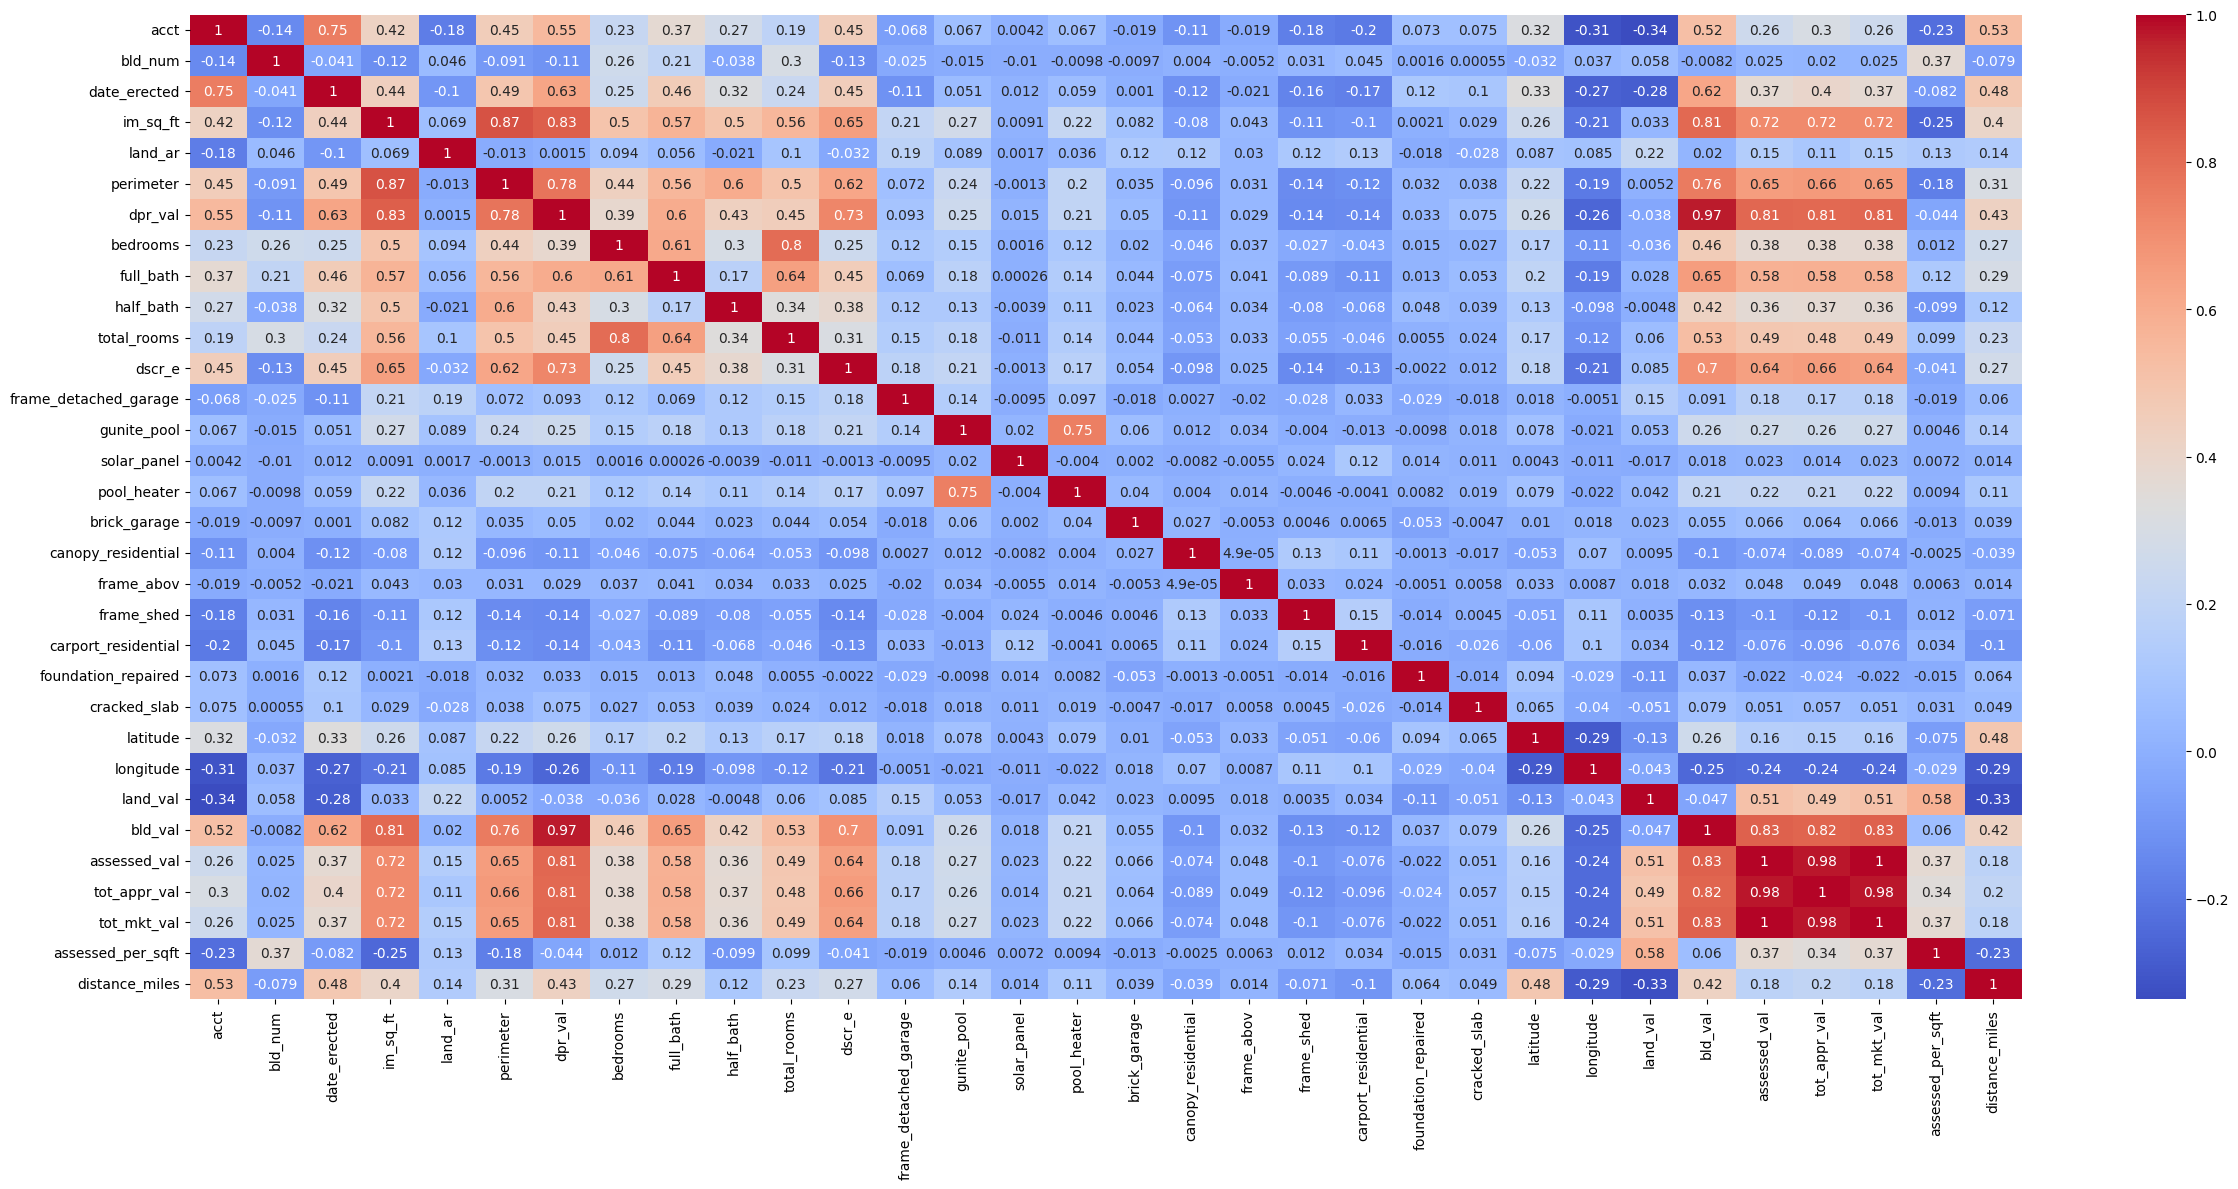

In [13]:
corr_matrix = sample_df.corr()
plt.figure(figsize=(25, 12))
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

In [14]:
X = sample_df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]

y = sample_df["assessed_val"]
print(f"There are {X.shape[1] + 1} features in total.")

There are 23 features in total.


# Train, Test, Split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [16]:
x_train.describe()

date_erected     im_sq_ft        land_ar    perimeter     bedrooms  \
count   8000.000000  8000.000000    8000.000000  8000.000000  8000.000000   
mean    1985.866000  1992.132000    8788.192875   257.846625     3.368375   
std       24.176453   728.392572   11044.829269    90.468819     0.792151   
min     1901.000000   200.000000       0.000000     0.000000     1.000000   
25%     1968.000000  1467.000000    5750.000000   192.000000     3.000000   
50%     1984.000000  1867.000000    7130.000000   232.000000     3.000000   
75%     2006.000000  2411.000000    8892.000000   316.000000     4.000000   
max     2023.000000  5550.000000  349891.000000   756.000000    15.000000   

         full_bath    half_bath  total_rooms     latitude    longitude  ...  \
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000  ...   
mean      2.015250     0.399500     6.790375    29.837444   -95.426864  ...   
std       0.623752     0.499431     1.619803     0.142840     0.208816  ...   
min       0.000000     0.000000     0.000000    29.502232   -95.926800  ...   
25%       2.000000     0.000000     6.000000    29.714487   -95.593941  ...   
50%       2.000000     0.000000     6.000000    29.839838   -95.435045  ...   
75%       2.000000     1.000000     8.000000    29.953616   -95.256572  ...   
max      10.000000     3.000000    30.000000    30.161979   -94.921015  ...   

        gunite_pool  pool_heater  brick_garage  canopy_residential  \
count   8000.000000  8000.000000   8000.000000          8000.00000   
mean     512.435625    88.539250    113.684875           112.26275   
std     2173.776940   515.622503   1091.999420           520.32354   
min        0.000000     0.000000      0.000000             0.00000   
25%        0.000000     0.000000      0.000000             0.00000   
50%        0.000000     0.000000      0.000000             0.00000   
75%        0.000000     0.000000      0.000000             0.00000   
max    44547.000000  6320.000000  36857.000000         12581.00000   

         frame_abov   frame_shed  carport_residential  foundation_repaired  \
count   8000.000000  8000.000000          8000.000000          8000.000000   
mean      79.949500   126.353875            93.792125          -129.596250   
std     1519.059784   487.066413           525.528627           974.658871   
min        0.000000     0.000000             0.000000        -12036.000000   
25%        0.000000     0.000000             0.000000             0.000000   
50%        0.000000     0.000000             0.000000             0.000000   
75%        0.000000     0.000000             0.000000             0.000000   
max    72679.000000  7716.000000         20869.000000             0.000000   

       cracked_slab  distance_miles  
count   8000.000000     8000.000000  
mean    -217.011875       15.670501  
std     1932.913033        6.978582  
min   -27520.000000        0.517687  
25%        0.000000       10.093846  
50%        0.000000       15.993098  
75%        0.000000       21.223764  
max        0.000000       40.227995  

[8 rows x 22 columns]

# Extra Random Trees
Using GridSearchCV for hyperparameter tuning. If this is done, it will increase the model's runtime to take several hours, and depending on the sample size and parameters, the computer may need up to 64 GB of RAM to process the models. If the computer has 32 GB, ensure the n_jobs = 4 or less. If the computer has 16gb of ram put n_jobs=1. n_jobs is the parallel jobs going simultaneously and consuming more resources. 

In [17]:
etr = ExtraTreesRegressor(random_state=42)
param_grid = {
    "n_estimators": [3000, 4000],
    "min_samples_leaf": [1],
    "min_samples_split": [2],
    "max_features": [X.shape[1] + 1],
    "criterion": ["squared_error"],
    "warm_start": [True],
}
etr_cv = GridSearchCV(etr, param_grid, cv=5, n_jobs=-1, scoring="r2")
# etr_cv = RandomizedSearchCV(etr, param_distributions=param_grid, cv=5, n_jobs=-1, scoring="r2", n_iter=200,
# return_train_score=True)
etr_cv.fit(x_train, y_train)

/home/specter/PycharmProjects/HouseProtestValues/.venv/lib64/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'max_features': [23],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [3000, 4000], 'warm_start': [True]},
             scoring='r2')

In [18]:
etr_cv.best_score_

np.float64(0.8128030391348672)

In [19]:
etr_cv.best_params_

{'criterion': 'squared_error',
 'max_features': 23,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 4000,
 'warm_start': True}

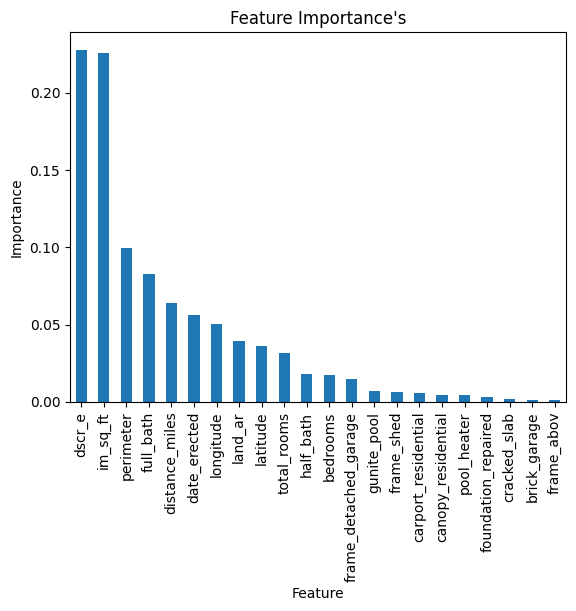

In [20]:
feature_names = [f"{i}" for i in X.columns]
best_model = etr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Graph the importance of the features
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title("Feature Importance's")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()


In [21]:
ert_cv_results = pd.DataFrame(etr_cv.cv_results_)
ert_cv_results["param_n_estimators"] = ert_cv_results["param_n_estimators"].astype(
    "category"
)
ert_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     125.271452      0.553195         1.908469        0.049920   
1     132.035487     28.337562         1.859728        0.294412   

  param_criterion  param_max_features  param_min_samples_leaf  \
0   squared_error                  23                       1   
1   squared_error                  23                       1   

   param_min_samples_split param_n_estimators  param_warm_start  \
0                        2               3000              True   
1                        2               4000              True   

                                              params  split0_test_score  \
0  {'criterion': 'squared_error', 'max_features':...           0.819801   
1  {'criterion': 'squared_error', 'max_features':...           0.819677   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.793240           0.818876           0.817430           0.814651   
1           0.793441           0.819120           0.817205           0.814571   

   mean_test_score  std_test_score  rank_test_score  
0         0.812800        0.009934                2  
1         0.812803        0.009844                1

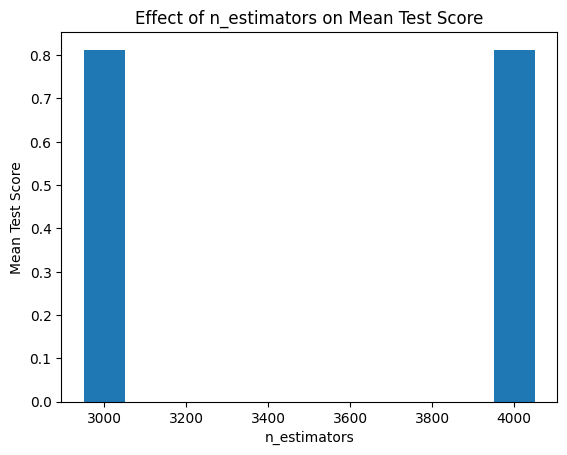

In [22]:
plt.bar(
    ert_cv_results["param_n_estimators"], ert_cv_results["mean_test_score"], width=100
)
plt.xlabel("n_estimators")
plt.ylabel("Mean Test Score")
plt.title("Effect of n_estimators on Mean Test Score")
plt.show()

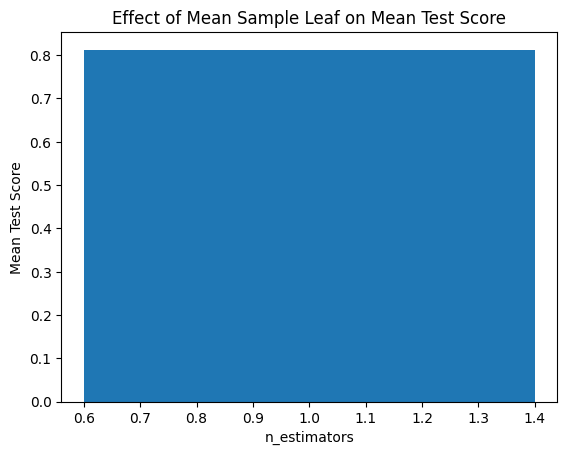

In [23]:
plt.bar(
    ert_cv_results["param_min_samples_leaf"],
    ert_cv_results["mean_test_score"],
    width=0.8,
)
plt.xlabel("n_estimators")
plt.ylabel("Mean Test Score")
plt.title("Effect of Mean Sample Leaf on Mean Test Score")
plt.show()

## Analysis of testing data

In [24]:
etc_pred = etr_cv.predict(x_test)
etc_mae = mean_absolute_error(y_test, etc_pred)
etc_mse = mean_squared_error(y_test, etc_pred)
etc_r2 = r2_score(y_test, etc_pred)
print(f"MAE: {etc_mae}\nMSE: {etc_mse}\nR Squared: {etc_r2}\n")

MAE: 33993.336478625
MSE: 2707813283.464539
R Squared: 0.8053946351529546



In [25]:
# Define the folder name
folder_name = "Models"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

# Get the current date
current_date = datetime.now()

# Format the date as YYYYmmdd
formatted_date = current_date.strftime("%Y%m%d")

joblib.dump(etr_cv, f"Models/etc_{formatted_date}.pkl")

Folder 'Models' already exists.


['Models/etc_20241129.pkl']

# Residual Analysis

In [26]:
actual = y_test.to_list()
predicted = etr_cv.predict(x_test)
etc_residuals = pd.DataFrame({"actual": actual, "predicted": predicted})
etc_residuals["residuals"] = etc_residuals["actual"] - etc_residuals["predicted"]

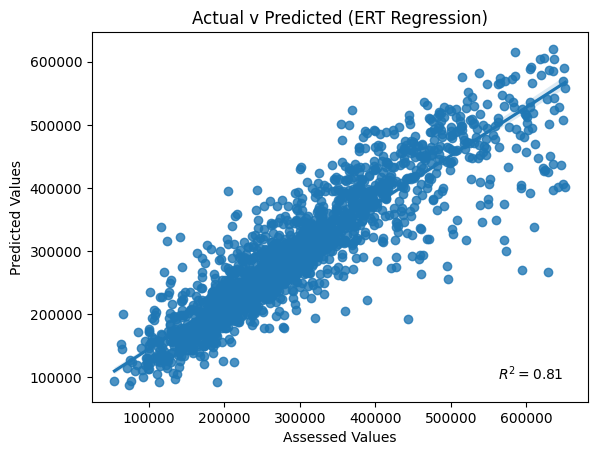

In [48]:
sns.regplot(etc_residuals, x="actual", y="predicted")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Actual v Predicted (ERT Regression)')

plt.text(0.95, 0.05, f"$R^2 = {etc_r2:.2f}$",
         horizontalalignment='right',
         verticalalignment='bottom',
         transform=plt.gca().transAxes,
         fontsize=10)
plt.show()

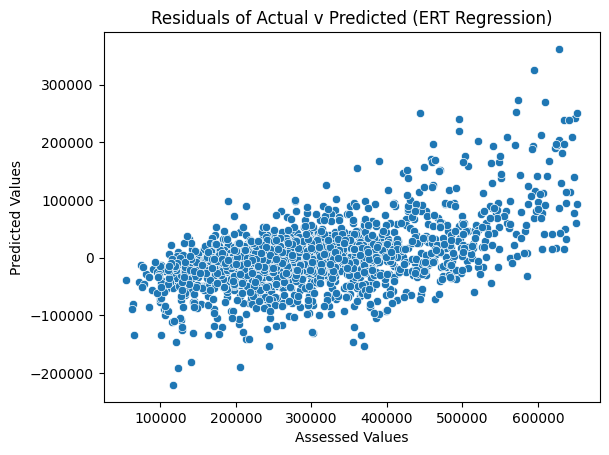

In [28]:
sns.scatterplot(etc_residuals, x="actual", y="residuals")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Residuals of Actual v Predicted (ERT Regression)')
plt.show()

## Gradient Boosting Regression

Gradient boosting is another ensemble algorithm that can be used much like Extra Random Trees. It differs in the way that it makes the trees. In gradient boosting new trees are added to correct errors of the previous tress in a sequential manner, while extra random trees builds tress independently by randomly selecting features and split points at each node, which makes it less prone to overfitting compared to gradient boosting which can be more sensitive to overfitting.

In [29]:
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    "n_estimators": [4000],
    "learning_rate": [0.005],
    "max_depth": [5],
    "min_samples_split": [3],
    "min_samples_leaf": [1],
    "max_features": [5,10,15,20,(X.shape[1] + 1)],
    "warm_start": [True],
    "criterion": ["friedman_mse"],
}
gbr_cv = GridSearchCV(gbr, param_grid, cv=5, n_jobs=4, scoring="r2")

In [30]:
gbr_cv.fit(x_train, y_train)
gbr_pred = gbr_cv.predict(x_test)

In [31]:
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)
print(f"MAE: {gbr_mae}\nMSE: {gbr_mse}\nR Squared: {gbr_r2}\n")

MAE: 31607.597788511248
MSE: 2219664781.3981495
R Squared: 0.8404769349275626



In [32]:
gbr_cv.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.005,
 'max_depth': 5,
 'max_features': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 4000,
 'warm_start': True}

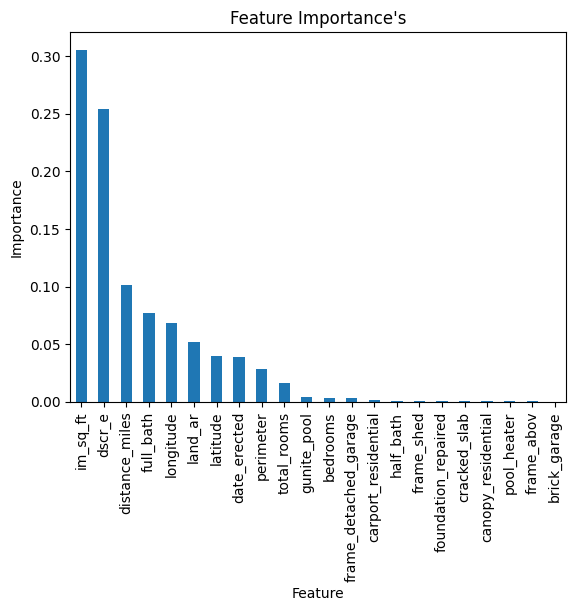

In [33]:
feature_names = [f"{i}" for i in X.columns]
best_model = gbr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Graph the importance of the features
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title("Feature Importance's")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [34]:
gbr_cv.best_score_

np.float64(0.8498034926161097)

In [35]:
joblib.dump(gbr_cv, "Models/gbr.pkl")

# load
# joblib.load('gbr.pkl')

['Models/gbr.pkl']

In [36]:
gbr_residual_df = pd.DataFrame(
    {
        "actual": actual,
        "predicted": gbr_pred,
    }
)
gbr_residual_df["residuals"] = gbr_residual_df["actual"] - gbr_residual_df["predicted"]

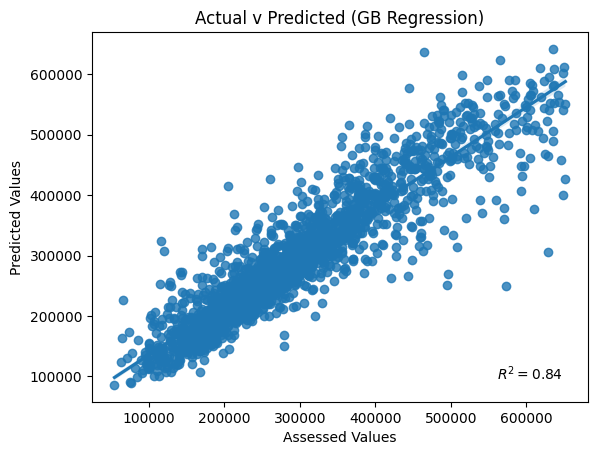

In [37]:
sns.regplot(gbr_residual_df, x="actual", y="predicted")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Actual v Predicted (GB Regression)')

plt.text(0.95, 0.05, f"$R^2 = {gbr_r2:.2f}$",
         horizontalalignment='right',
         verticalalignment='bottom',
         transform=plt.gca().transAxes,
         fontsize=10)
plt.show()

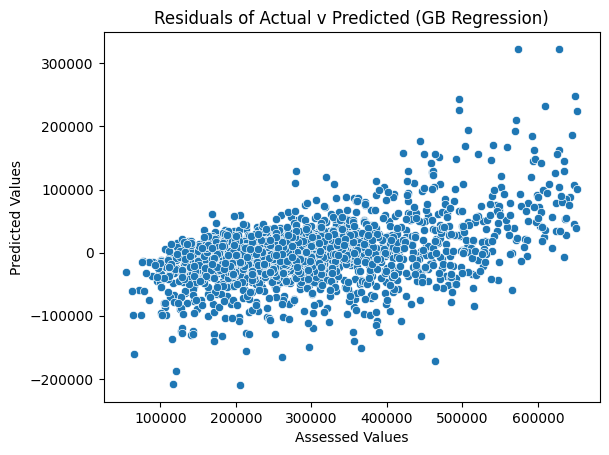

In [38]:
sns.scatterplot(gbr_residual_df, x="actual", y="residuals")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Residuals of Actual v Predicted (GB Regression)')
plt.show()

# Apply model to entire dataset
The model was created with a random subset of the data to reduce the training time. This will apply the model to the rest of the dataset.

In [39]:
df

acct  bld_num  date_erected  im_sq_ft  land_ar  perimeter  \
1          21440000001        1          2004      2537     5000        314   
2          21480000002        1          1917      1496     5000        186   
4          21650000011        1          2003      1508     6250        210   
5          21660000011        1          1940      1670     6250        186   
8          21700000013        1          1920      1434     2110        170   
...                ...      ...           ...       ...      ...        ...   
1121037  1938003804013        1          2003      2117     5250        318   
1121038  1938003804014        1          2003      1611     5250        184   
1121039  1953050320690        1          1979      2168     6820        232   
1121040  1953080320060        1          1983      1723     7575        216   
1121041  1955020050280        1          1979      1374     8851        250   

        dpr_val  bedrooms  full_bath  half_bath  ...  cracked_slab   latitude  \
1        307658       3.0        2.0        1.0  ...             0  29.740005   
2          9621       3.0        1.0        0.0  ...             0  29.742185   
4        172034       3.0        2.0        0.0  ...             0  29.741294   
5         15157       2.0        2.0        0.0  ...             0  29.741809   
8         68013       2.0        1.0        1.0  ...             0  29.743686   
...         ...       ...        ...        ...  ...           ...        ...   
1121037  235142       3.0        2.0        1.0  ...             0  29.594555   
1121038  205392       3.0        2.0        0.0  ...             0  29.594558   
1121039  201010       3.0        2.0        0.0  ...             0  29.694444   
1121040  181811       3.0        2.0        0.0  ...             0  29.694102   
1121041  160896       3.0        2.0        1.0  ...             0  29.702614   

         longitude  land_val   bld_val  assessed_val  tot_appr_val  \
1       -95.358428  200000.0  307658.0      510178.0      311246.0   
2       -95.361765  200000.0    9486.0      209586.0      209586.0   
4       -95.361493  225000.0  172034.0      397034.0      388778.0   
5       -95.362342  225000.0   14318.0      239318.0      239318.0   
8       -95.365546  137150.0   68013.0      206372.0      206372.0   
...            ...       ...       ...           ...           ...   
1121037 -95.453635   35438.0  233603.0      269041.0      269041.0   
1121038 -95.453478   35438.0  204053.0      239491.0      166883.0   
1121039 -95.658936   54560.0  201010.0      255570.0      240372.0   
1121040 -95.658271   55740.0  173156.0      228896.0      228896.0   
1121041 -95.673357   64580.0  160896.0      225476.0      216585.0   

         tot_mkt_val  assessed_per_sqft  distance_miles  
1           510178.0         201.094994        1.554979  
2           209586.0         140.097594        1.334974  
4           397034.0         263.285146        1.398188  
5           239318.0         143.304192        1.346758  
8           206372.0         143.913529        1.166515  
...              ...                ...             ...  
1121037     269041.0         127.085971       12.489168  
1121038     239491.0         148.659839       12.485174  
1121039     255570.0         117.882841       17.914352  
1121040     228896.0         132.847359       17.881794  
1121041     225476.0         164.101892       18.623451  

[1017072 rows x 32 columns]

In [40]:
X = df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]
df['ert_predicted'] = etr_cv.predict(X)
df['gbr_predicted'] = gbr_cv.predict(X)

In [41]:
df[['assessed_val', 'ert_predicted', 'gbr_predicted']]

assessed_val  ert_predicted  gbr_predicted
1            510178.0   474707.94700  491359.575585
2            209586.0   252416.51450  303858.333392
4            397034.0   315250.71550  360055.594794
5            239318.0   286372.82850  291815.630133
8            206372.0   265731.97425  214566.556632
...               ...            ...            ...
1121037      269041.0   272320.82800  265675.715181
1121038      239491.0   236591.84800  232541.042985
1121039      255570.0   262500.55750  256962.980890
1121040      228896.0   236621.91725  229364.222619
1121041      225476.0   208376.67725  219425.083179

[1017072 rows x 3 columns]

# Merge Mailing Address
Merge the Mailing Address information with the properties to protest

In [42]:
# Get mailing address
con = sqlite3.connect("HouseProtestValues.db")
sql_address = """SELECT acct,
                        mailto,
                        mail_addr_1,
                        mail_addr_2,
                        Mail_city,
                        mail_state,
                        mail_zip
                FROM real_acct;"""
mail_addr = pd.read_sql_query(sql_address, con)

df = df.merge(mail_addr, left_on='acct', right_on='acct')
df

acct  bld_num  date_erected  im_sq_ft  land_ar  perimeter  \
0          21440000001        1          2004      2537     5000        314   
1          21480000002        1          1917      1496     5000        186   
2          21650000011        1          2003      1508     6250        210   
3          21660000011        1          1940      1670     6250        186   
4          21700000013        1          1920      1434     2110        170   
...                ...      ...           ...       ...      ...        ...   
1017067  1938003804013        1          2003      2117     5250        318   
1017068  1938003804014        1          2003      1611     5250        184   
1017069  1953050320690        1          1979      2168     6820        232   
1017070  1953080320060        1          1983      1723     7575        216   
1017071  1955020050280        1          1979      1374     8851        250   

        dpr_val  bedrooms  full_bath  half_bath  ...  assessed_per_sqft  \
0        307658       3.0        2.0        1.0  ...         201.094994   
1          9621       3.0        1.0        0.0  ...         140.097594   
2        172034       3.0        2.0        0.0  ...         263.285146   
3         15157       2.0        2.0        0.0  ...         143.304192   
4         68013       2.0        1.0        1.0  ...         143.913529   
...         ...       ...        ...        ...  ...                ...   
1017067  235142       3.0        2.0        1.0  ...         127.085971   
1017068  205392       3.0        2.0        0.0  ...         148.659839   
1017069  201010       3.0        2.0        0.0  ...         117.882841   
1017070  181811       3.0        2.0        0.0  ...         132.847359   
1017071  160896       3.0        2.0        1.0  ...         164.101892   

         distance_miles  ert_predicted  gbr_predicted  \
0              1.554979   474707.94700  491359.575585   
1              1.334974   252416.51450  303858.333392   
2              1.398188   315250.71550  360055.594794   
3              1.346758   286372.82850  291815.630133   
4              1.166515   265731.97425  214566.556632   
...                 ...            ...            ...   
1017067       12.489168   272320.82800  265675.715181   
1017068       12.485174   236591.84800  232541.042985   
1017069       17.914352   262500.55750  256962.980890   
1017070       17.881794   236621.91725  229364.222619   
1017071       18.623451   208376.67725  219425.083179   

                                                 mailto  \
0                              TREWICK MICHAEL & MEGONE   
1                           SMITH SAMPSON AND BEENE LLC   
2                                  BROOKS LONNIE & LISA   
3                                   JEWELL MELVIN & LOU   
4                              MENDEZ JORGE O & ANGELES   
...                                                 ...   
1017067                               HERNANDEZ ALFREDO   
1017068                                   REYES EULALIA   
1017069                       CARRENS JAY 1953050320690   
1017070  SFR-HOU I LLC V KHEMKA & UMA V KHEMKA TRUSTEES   
1017071                                    MONGE OLGA Y   

                      mail_addr_1  mail_addr_2      mail_city  mail_state  \
0                2120 LIVE OAK ST                     HOUSTON          TX   
1        440 LOUISIANA ST STE 900                     HOUSTON          TX   
2                 2212 WEBSTER ST                     HOUSTON          TX   
3             1230 LEXINGTON BLVD               MISSOURI CITY          TX   
4        3389 W HIGHWAY 98 UNIT 7                 MARY ESTHER          FL   
...                           ...          ...            ...         ...   
1017067           16510 DETRIC LN                     HOUSTON          TX   
1017068      4835 BRYANT RIDGE RD                     HOUSTON          TX   
1017069         7307 EL CRESTA DR                     HOUSTON          TX   
1017

# Properties that should be protested

In [43]:
protest_ert = df.query('assessed_val <= ert_predicted')
protest_gbr = df.query('assessed_val <= gbr_predicted')

In [44]:
total = df.shape[0]
count_ert = protest_ert.shape[0]
count_gbr = protest_gbr.shape[0]
print(f"Total Accounts: {total}, Extra Trees: {count_ert}, Gradient Boosting Regressor: {count_gbr}")

Total Accounts: 1017072, Extra Trees: 542659, Gradient Boosting Regressor: 522521


In [45]:
# Define the folder name
folder_name = "Output"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")


def output_dataframe_csv(df_name, name):
    df_name.to_csv(f"Output/{name}.csv", index=False)


Folder 'Output' already exists.


In [46]:
output_dataframe_csv(df, "All_Data")
output_dataframe_csv(protest_ert, "Protest_Data_Extra_Trees")
output_dataframe_csv(protest_gbr, "Protest_Data_Extra_GBR")

## Proportions of homes to be send advertiments

In [47]:
percent_etr = (count_ert / total) * 100
percent_gbr = (count_gbr / total) * 100
print(
    f"Extra Random Trees regression model predicts that {percent_etr:.2f}% of total accounts should be protested.\nGradient Boosting Regressor: {percent_gbr:.2f}% of total accounts.")

Extra Random Trees regression model predicts that 53.36% of total accounts should be protested.
Gradient Boosting Regressor: 51.38% of total accounts.
